In [4]:
from dotenv import load_dotenv
import sys

sys.path.append("../../common")
load_dotenv()

True

In [8]:
import os
from langsmith_tracker import set_tracking

# 인스턴스를 생성할 때 필요한 매개변수를 전달합니다.
set_tracking(project_name="17.LangGraph")

Langsmith 추적이 활성화되었습니다. [프로젝트명: 17.LangGraph]


### Agent 에 메모리(Memory) 추가

LangGraph 에서는 메모리를 추가하기 위한 방법입니다.  
  
`LangGraph`에서는 **persistent checkpointing** 을 통해 메모리 기능을 사용합니다.  
  
그래프를 컴파일할때!, `checkpointer`를 제공하고 그래프를 호출할 때! `thread_id`를 제공하면, `LangGraph`는 각 단계 후 **상태를 자동으로 저장**합니다. 동일한 `thread_id`를 사용하여 그래프를 호출하면, 그래프는 저장된 상태를 로드하여 챗봇이 이전에 중단한 지점에서 대화를 이어갈 수 있습니다.  
  
**checkpointing** 은 LangChain 의 메모리 기능보다 훨씬 강력합니다.

멀티턴(multi-turn) 대화를 가능하게 하기 위해 **checkpointing**을 추가하기 위해 `MemorySaver`를 생성합니다.   
  
`MemorySaver`는 메모리를 저장하고 로드하는 역할을 합니다. 
  
메모리를 생성하는 여러가지입니다. 이번 예제에서는 `in-memory` 방식을 사용합니다.   
  
프로덕션 단계에서는 이것을 `SqliteSaver` 또는 `PostgresSaver` 로 변경하고 DB에 연결하여 사용할 수 있습니다.   


#### LLM의 도구 바인딩과 툴 노드 구성하는 이유

이것은 LangGraph에서 도구(Tool)를 사용할 때의 중요한 아키텍처적 구분입니다. 두 부분에서 도구를 설정하는 이유는 다음과 같습니다:

1. LLM의 bind_tools
- 이것은 LLM이 도구의 존재를 **"인식"하고 도구를 "호출하기 위한" 것**입니다
- LLM에게 어떤 도구들이 사용 가능한지 알려주는 역할을 합니다
- LLM은 이를 통해 도구 호출을 위한 함수 콜을 생성할 수 있게 됩니다

2. Tool Node의 도구
- 이것은 실제로 도구를 **"실행"하기 위한 것**입니다
- LLM이 도구 호출을 요청했을 때, 실제로 그 도구를 실행하는 역할을 담당합니다
- 도구 노드는 LLM이 생성한 함수 콜을 받아서 실제 도구를 실행하고 결과를 반환합니다. 즉, 이것은 "계획"과 "실행"의 분리라고 볼 수 있습니다:
- LLM은 도구를 사용하기로 "계획"합니다 (bind_tools)
- Tool Node는 그 계획을 실제로 "실행"합니다 (BasicToolNode)

이러한 분리는 관심사의 분리(Separation of Concerns) 원칙을 따르며, 각 컴포넌트가 자신의 역할에만 집중할 수 있게 해줍니다.

In [15]:
from langgraph.checkpoint.memory import MemorySaver

# 메모리 저장소 생성
memory = MemorySaver()

In [14]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from tools_tavily import TavilySearch
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


##### 1. 상태(State) 정의
class State(TypedDict):
    # 메모리 저장소 추가
    messages: Annotated[list, add_messages]


##### 2. 도구 정의 및 바인딩
# 도구 초기화
tool = TavilySearch()
tools = [tool]

# llm 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# llm과 도구 바인디
llm_with_tools = llm.bind_tools(tools)


##### 3. 노드 추가
# 챗봇 함수 정의, 노드 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": llm_with_tools.invoke(state["messages"])}


# 상태 그래프 생성
graph_builder = StateGraph(State)

# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)

# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=[tool])

# 도구 노드 추가
graph_builder.add_node("tools", tool_node)

# 조건부 엣지
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

##### 4. 엣지 추가
# START > chatbot
graph_builder.add_edge(START, "chatbot")

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# chatbot > END
graph_builder.add_edge("chatbot", END)

`checkerpointer` 를 사용하여 그래프를 컴파일합니다.

In [17]:
graph = graph_builder.compile(checkpointer=memory)

그래프가 각 노드를 처리하면서 `State` 를 체크포인트(저장하고 로드)합니다.

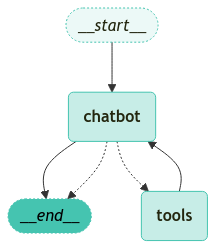

In [18]:
from graphs import visualize_graph

visualize_graph(graph)

#### Runnable Config 설정

RunnableConfig는 LangChain의 실행 가능한 컴포넌트(Runnable)의 동작을 구성하는 데 사용되는 설정 클래스입니다. 주요 파라미터들은 다음과 같습니다:  
  
**사용 목적**
  
1. 실행 제어:
    - 재귀 한계, 동시성 제한 등을 통해 실행을 제어
    - 안전하고 예측 가능한 동작 보장

2. 상태 관리:
    - thread_id를 통해 대화 세션의 상태를 추적
    - 메모리와 체크포인트 기능을 활용 가능

3. 모니터링과 디버깅:
    - 콜백과 메타데이터를 통해 실행을 모니터링
    - 문제 해결을 위한 정보 제공

예제에서는 recursion_limit와 thread_id만 사용되었지만, 필요에 따라 다른 파라미터들을 추가하여 더 세밀한 제어가 가능합니다.  
  
  
**주요 파라미터**  
1. recursion_limit (int, optional)
    - 재귀 호출의 최대 깊이를 제한
    - 무한 루프를 방지하기 위한 안전장치
    - 예제에서는 10으로 설정되어 있음
2. thread_id (str, optional)
    -  대화 세션을 구분하는 고유 식별자
    - 메모리/체크포인트 기능에서 상태를 저장하고 불러올 때 사용
    - 다른 대화 세션과 구분하기 위해 사용

3. 그 외 주요 파라미터들 
```python
   RunnableConfig(
       callbacks: Optional[List[BaseCallbackHandler]] = None,  # 콜백 핸들러
       tags: Optional[List[str]] = None,  # 실행을 태깅하기 위한 문자열 리스트
       metadata: Optional[Dict[str, Any]] = None,  # 추가 메타데이터
       run_name: Optional[str] = None,  # 실행의 이름
       configurable: Optional[Dict[str, Any]] = None,  # 구성 가능한 필드
       max_concurrency: Optional[int] = None,  # 동시 실행 제한
       run_traceback: bool = False,  # 트레이스백 포함 여부
   )
```

In [24]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문, 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 생성
)

In [31]:
# 첫 질문
question = "코인은 가상자산입니다. 대표적으로, `비트코인, 이더리움, 솔라나` 등이 있습니다. 제가 보유한 코인은 `솔라나` 입니다."

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"].pretty_print()

================================== Ai Message ==================================

솔라나(Solana)는 빠른 거래 속도와 낮은 수수료로 유명한 블록체인 플랫폼입니다. DeFi(탈중앙화 금융)와 NFT(대체 불가능한 토큰) 생태계에서 많은 인기를 끌고 있으며, 다양한 프로젝트와 애플리케이션이 솔라나 네트워크에서 운영되고 있습니다.

솔라나의 주요 특징 중 하나는 높은 처리량을 자랑하는데, 이는 많은 거래를 동시에 처리할 수 있는 능력을 의미합니다. 또한, 개발자들이 쉽게 애플리케이션을 구축할 수 있도록 다양한 도구와 리소스를 제공하고 있습니다.

솔라나에 대해 더 알고 싶거나, 특정 질문이 있으신가요?


In [32]:
# 이어지는 질문
question = "제가 보유한 코인의 이름은 무엇인가요?"

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"].pretty_print()

================================== Ai Message ==================================

당신이 보유한 코인의 이름은 **솔라나(Solana)**입니다.


스레드 아이디를 변경한 뒤, 이전의 대화를 기억하는지 확인합니다. 예사으로는 기억하고 있지 않아야 합니다.

In [33]:
from langchain_core.runnables import RunnableConfig

question = "제가 보유한 코인의 이름은 무엇인가요?"

config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "2"},  # 스레드 ID 설정
)

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"].pretty_print()

================================== Ai Message ==================================

보유하고 있는 코인의 이름을 알기 위해서는 추가적인 정보가 필요합니다. 어떤 코인을 보유하고 있는지에 대한 정보를 제공해 주시면, 그에 대한 도움을 드릴 수 있습니다.


#### 스냅샷: 정의된 State 확인

`Checkpoint` 에는 현재 상태 값, 해당 구성, 그리고 처리할 `next` 노드가 포함되어 있습니다.  
  
그래프의 `state` 를 검사하기 위해서는 `get_state(config)` 함수를 사용합니다.

In [34]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    configurable={"thread_id": "1"},  # 스레드 ID 설정
)
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)
snapshot.values["messages"]

[HumanMessage(content='코인은 가상자산입니다. 대표적으로, `비트코인, 이더리움, 솔라나` 등이 있습니다.', additional_kwargs={}, response_metadata={}, id='7da7afe9-28bf-49d1-8a4f-14cf4d3f0a91'),
 AIMessage(content='맞습니다! 코인은 가상자산의 일종으로, 디지털 형태로 존재하며 블록체인 기술을 기반으로 합니다. 비트코인(BTC)은 최초의 암호화폐로 가장 널리 알려져 있으며, 이더리움(ETH)은 스마트 계약 기능을 제공하는 플랫폼으로 유명합니다. 솔라나(SOL)는 빠른 거래 속도와 낮은 수수료로 주목받고 있는 블록체인입니다. 이 외에도 많은 다른 코인들이 있으며, 각각의 특성과 용도가 다릅니다. 추가로 궁금한 점이 있으신가요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 132, 'prompt_tokens': 120, 'total_tokens': 252, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bba3c8e70b', 'finish_reason': 'stop', 'logprobs': None}, id='run-59dd1393-a8b0-45ba-b3fa-8b518d76fd14-0', usage_metadata={'input_tokens': 120, 'output_tokens': 132, 'total_

`snapshot.config` 를 통해 config 정보를 확인할 수 있습니다.

In [35]:
snapshot.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efb6c28-e041-658e-8016-c5b891dfb0bd'}}

`snapshot.values` 로 지금까지 저장된 state 값을 확인할 수 있습니다.

In [37]:
snapshot.values

{'messages': [HumanMessage(content='코인은 가상자산입니다. 대표적으로, `비트코인, 이더리움, 솔라나` 등이 있습니다.', additional_kwargs={}, response_metadata={}, id='7da7afe9-28bf-49d1-8a4f-14cf4d3f0a91'),
  AIMessage(content='맞습니다! 코인은 가상자산의 일종으로, 디지털 형태로 존재하며 블록체인 기술을 기반으로 합니다. 비트코인(BTC)은 최초의 암호화폐로 가장 널리 알려져 있으며, 이더리움(ETH)은 스마트 계약 기능을 제공하는 플랫폼으로 유명합니다. 솔라나(SOL)는 빠른 거래 속도와 낮은 수수료로 주목받고 있는 블록체인입니다. 이 외에도 많은 다른 코인들이 있으며, 각각의 특성과 용도가 다릅니다. 추가로 궁금한 점이 있으신가요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 132, 'prompt_tokens': 120, 'total_tokens': 252, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bba3c8e70b', 'finish_reason': 'stop', 'logprobs': None}, id='run-59dd1393-a8b0-45ba-b3fa-8b518d76fd14-0', usage_metadata={'input_tokens': 120, 'output_tokens'

`snapshot.next` 로 다음 노드를 확인할 수 있습니다.

In [38]:
snapshot.next

()

In [40]:
snapshot.metadata["writes"]["chatbot"]["messages"]

AIMessage(content='당신이 보유한 코인의 이름은 **솔라나(Solana)**입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 1669, 'total_tokens': 1689, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1536}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bba3c8e70b', 'finish_reason': 'stop', 'logprobs': None}, id='run-44f0abd2-f599-43d3-9355-b7ce94c43ab1-0', usage_metadata={'input_tokens': 1669, 'output_tokens': 20, 'total_tokens': 1689, 'input_token_details': {'audio': 0, 'cache_read': 1536}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [41]:
from langchain_print import display_message_tree

# 메타데이터 tree 형태로 출력
display_message_tree(snapshot.metadata)

[source]:
    source: loop
[writes]:
    [chatbot]:
        [messages]:
            messages: content='당신이 보유한 코인의 이름은 **솔라나(Solana)**입니다.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 1669, 'total_tokens': 1689, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1536}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bba3c8e70b', 'finish_reason': 'stop', 'logprobs': None} id='run-44f0abd2-f599-43d3-9355-b7ce94c43ab1-0' usage_metadata={'input_tokens': 1669, 'output_tokens': 20, 'total_tokens': 1689, 'input_token_details': {'audio': 0, 'cache_read': 1536}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
[thread_id]:
    thread_id: 1
[step]:
    step: 22
[parents]:
